In [40]:
from aiida.orm import Dict, Str,List,Code,FolderData,RemoteData,Float,Int,ArrayData,load_code
from aiida.engine import run,run_get_node,ExitCode,WorkChain,workfunction,calcfunction
from aiida.plugins import DataFactory
import os
import numpy as np

from cryspy.job import ctrl_job

StructureCollectionData = DataFactory("cryspy.structurecollection")
PandasFrameData = DataFactory('dataframe.frame')
RinData = DataFactory('cryspy.rin_data')
LammpsPotentialData = DataFactory("lammps.potential")
LammpsTrajectoryData = DataFactory("lammps.trajectory")
StructureData = DataFactory('core.structure')

In [41]:
from aiida import load_profile
load_profile()

Profile<uuid='96abe6da047b431294d9057e5dbc634c' name='quicksetup'>

In [42]:

class initialize_workchain(WorkChain):
    
    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("cryspy_in_filename",valid_type=Str)
        #lock_cryspyをinputで入れる？
        
        spec.output("initial_structures",valid_type=StructureCollectionData)
        # spec.output("opt_struc_data",valid_type=Dict)
        # spec.output("rin",valid_type=RinData)
        spec.output("rslt_data",valid_type=PandasFrameData)
        spec.output("cryspy_in",valid_type=RinData)
        spec.output("id_queueing",valid_type=List)
        
        # spec.output("id_data",valid_type=Dict)
        # spec.output("deatai_data",valid_type=Dict)

        
        
        
        spec.outline(
            cls.call_crsypy_initialize
        )
        
    def call_crsypy_initialize(self):
        from cryspy.interactive import action
        init_struc_data, opt_struc_data, rin, rslt_data, id_queueing = action.initialize()
        


        init_struc_node = StructureCollectionData(structures=init_struc_data)
        init_struc_node.store()
        self.out('initial_structures', init_struc_node)
        rslt_node = PandasFrameData(rslt_data)
        rslt_node.store()
        self.out('rslt_data', rslt_node)
        
        cryspy_in = RinData(rin)
        cryspy_in.store()
        self.out("cryspy_in", cryspy_in)
        
        id_queueing_node = List(list=id_queueing)
        id_queueing_node.store()
        self.out("id_queueing", id_queueing_node)

In [43]:
result,node = run.get_node(initialize_workchain, cryspy_in_filename="cryspy_in")

[2025-06-24 17:48:02,002][cryspy_init][INFO] 


Start CrySPY 1.4.0b10


[2025-06-24 17:48:02,006][cryspy_init][INFO] # ---------- Library version info
[2025-06-24 17:48:02,006][cryspy_init][INFO] pandas version: 2.2.2
[2025-06-24 17:48:02,012][cryspy_init][INFO] pymatgen version: 2024.6.10
[2025-06-24 17:48:02,012][cryspy_init][INFO] pyxtal version: 0.6.7
[2025-06-24 17:48:02,012][cryspy_init][INFO] # ---------- Read input file, cryspy.in
[2025-06-24 17:48:02,018][write_input][INFO] [basic]
[2025-06-24 17:48:02,018][write_input][INFO] algo = RS
[2025-06-24 17:48:02,019][write_input][INFO] calc_code = ASE
[2025-06-24 17:48:02,020][write_input][INFO] tot_struc = 3
[2025-06-24 17:48:02,020][write_input][INFO] nstage = 1
[2025-06-24 17:48:02,020][write_input][INFO] njob = 2
[2025-06-24 17:48:02,020][write_input][INFO] jobcmd = zsh
[2025-06-24 17:48:02,028][write_input][INFO] jobfile = job_cryspy
[2025-06-24 17:48:02,028][write_input][INFO] 
[2025-06-24 17:48:02,029][write_input][INFO] [str

/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:63: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df.to_hdf(Path(td) / self.DEFAULT_FILENAME, "w", format="table")
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:68: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("_pandas_data_hash", self._hash_dataframe(df))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python3.12/site-packages/aiida_dataframe/data/dataframe.py:69: AiidaDeprecationWarning: `PandasFrameData.set_attribute` is deprecated, use `PandasFrameData.base.attributes.set` instead. (this will be removed in v3)
  self.set_attribute("index", list(df.index))
/Users/moriireo/workspace/aiida_CrySPY_nim/lib/python

In [44]:
result

{'initial_structures': <StructureCollectionData: uuid: 64bcbd27-e406-4a2b-aca9-e72c3fe216a1 (pk: 7017)>,
 'rslt_data': <PandasFrameData: uuid: 5d48d308-8e93-4d10-83f6-4d1b679694e9 (pk: 7018)>,
 'cryspy_in': <RinData: uuid: a6236a88-3dc2-4250-8d7d-224c8a2f3dc6 (pk: 7019)>,
 'id_queueing': <List: uuid: 195faf5f-436d-4f27-9cc7-ec4fb32948e4 (pk: 7020) value: [0, 1, 2]>}

Success: Output written to `7016.dot.pdf`


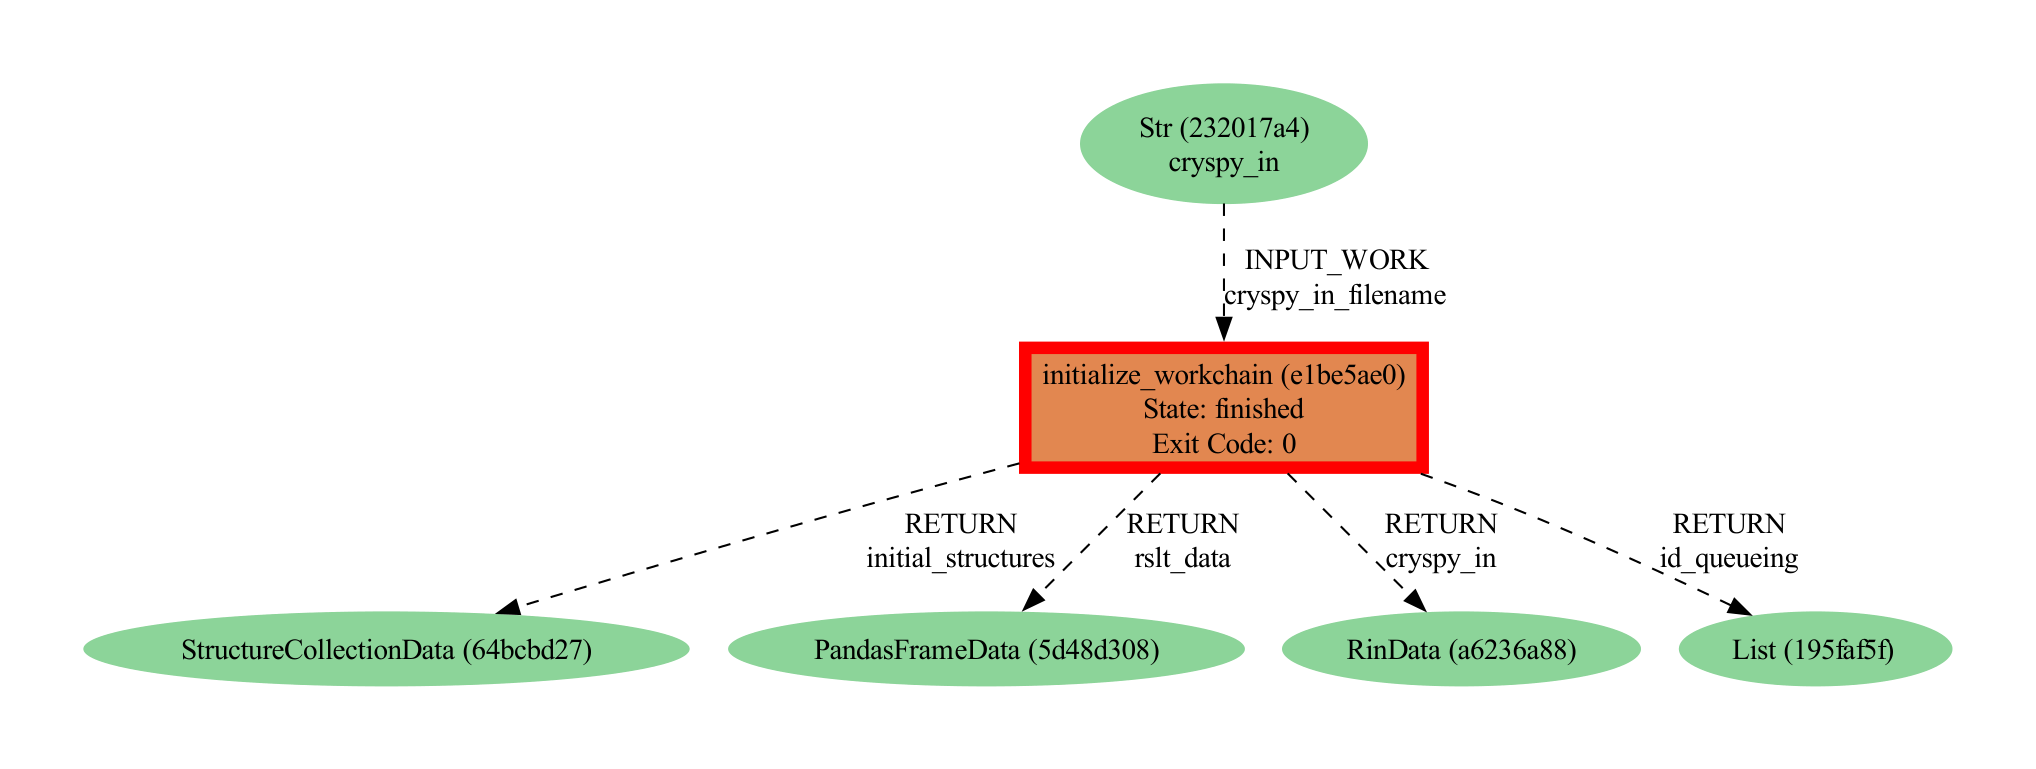

In [45]:
import subprocess
import fitz  # PyMuPDF
from PIL import Image
import io
from IPython.display import display

# ノードの pk を取得
pk = node.pk

# Step 1: verdi コマンドで .dot.pdf を生成
subprocess.call(f"verdi node graph generate {pk}", shell=True)

# Step 2: PyMuPDF で PDF を開いて画像化
pdf_path = f"{pk}.dot.pdf"
doc = fitz.open(pdf_path)
page = doc[0]
pix = page.get_pixmap(dpi=150)

# Step 3: PIL で画像として表示
image = Image.open(io.BytesIO(pix.tobytes()))
display(image)


In [46]:
from pathlib import Path

# ポテンシャルデータを含むテキストファイルを準備
pair_style = 'tersoff'
potential_dict = {
    'Ga Ga Ga': '1.0 0.007874 1.846 1.918000 0.75000 -0.301300 1.0 1.0 1.44970 410.132 2.87 0.15 1.60916 535.199',
    'N  N  N': '1.0 0.766120 0.000 0.178493 0.20172 -0.045238 1.0 1.0 2.38426 423.769 2.20 0.20 3.55779 1044.77',
    'Ga Ga N': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 0.0 0.00000 0.00000 2.90 0.20 0.00000 0.00000',
    'Ga N  N': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 1.0 2.63906 3864.27 2.90 0.20 2.93516 6136.44',
    'N  Ga Ga': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 1.0 2.63906 3864.27 2.90 0.20 2.93516 6136.44',
    'N  Ga N ': '1.0 0.766120 0.000 0.178493 0.20172 -0.045238 1.0 0.0 0.00000 0.00000 2.20 0.20 0.00000 0.00000',
    'N  N  Ga': '1.0 0.001632 0.000 65.20700 2.82100 -0.518000 1.0 0.0 0.00000 0.00000 2.90 0.20 0.00000 0.00000',
    'Ga N  Ga': '1.0 0.007874 1.846 1.918000 0.75000 -0.301300 1.0 0.0 0.00000 0.00000 2.87 0.15 0.00000 0.00000'
}

potential_file = Path.cwd() / 'potential.txt'
with potential_file.open('w') as f:
    for key, value in potential_dict.items():
        f.write(f'{key} {value}\n')



# ノードを作成
potential = LammpsPotentialData.get_or_create(
    source=potential_file,
    filename="potential.txt",
    pair_style="tersoff",
    species=["Ga", "N"],
    atom_style="atomic",
    units="metal"
)

In [47]:
parameters = Dict({
    "control": {
        "units": "metal",
        "timestep": 0.001
    },
    "structure": {
        "atom_style": "atomic"
    },
    "minimize": {
        "style": "cg",
        "energy_tolerance": 1e-6,
        "force_tolerance": 1e-6,
        "max_iterations": 1000,
        "max_evaluations": 10000
    },
    "thermo": {
        "printing_rate": 100
    }
})

In [ ]:
# #わざと失敗させるためのパラメータ

# parameters = Dict({
#     "control": {
#         "units": "metal",
#         "timestep": 0.001
#     },
#     "structure": {
#         "atom_style": "INVALID_STYLE"  # 存在しない atom_style
#     },
#     "minimize": {
#         "style": "nonexistent_style",  # 存在しない minimize
#         "energy_tolerance": 1e-6,
#         "force_tolerance": 1e-6,
#         "max_iterations": 1000,
#         "max_evaluations": 10000
#     },
#     "thermo": {
#         "printing_rate": 100
#     }
# })


In [48]:
SIMULATOR_PREFIX = 'simulator_'
ID_PREFIX = 'ID_'


class optimization_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input("structure", valid_type=StructureData, help='selected structure for optimization')
        spec.input('potential', valid_type=LammpsPotentialData, help='lammps potential')
        spec.input('parameters', valid_type=Dict, help='additional parameters to pass \'lammps.base\'')
        spec.input('options', valid_type=Dict, default=Dict, help='metadata.options')

        spec.outline(
            cls.submit_workchains,
            cls.inspect_workchains
        )
        
        spec.output("remote_folder",valid_type=RemoteData, help='remote folder of the workchain')
        spec.output("results", valid_type=Dict, help='results of all workchains')
        spec.output("retrieved", valid_type=FolderData, help='retrieved data from the workchain')
        spec.output("time_dependent_computes",valid_type=ArrayData, help='time dependent computes from the workchain')
        spec.output("structure", valid_type=StructureData, help='optimized structure from the workchain')
        # spec.output("retrieved", valid_type=FolderData)
        # spec.output("opt_structure", valid_type=StructureData)


    def submit_workchains(self):
        # initial_structures_dict = self.inputs.initial_structures.structurecollection #初期構造をpymatgenの構造として取得
        code = self.inputs.code
        structure = self.inputs.structure
        potential = self.inputs.potential
        parameters = self.inputs.parameters
        metadata_options = self.inputs.options.get_dict()


        builder = code.get_builder()
        builder.structure = structure
        builder.potential = potential
        builder.parameters = parameters
        builder.metadata.options = metadata_options
        # submit workchain
        future = self.submit(builder)
        self.to_context(my_future=future)
        
        # if 'results' in future.outputs:
        #     self.out("results", future.outputs.results)
        
        
    def inspect_workchains(self):
        calculations = self.ctx.my_future

        if 'remote_folder' in calculations.outputs:
            self.out("remote_folder", calculations.outputs.remote_folder)
        if 'results' in calculations.outputs:
            self.out("results", calculations.outputs.results)
        if 'retrieved' in calculations.outputs:
            self.out("retrieved", calculations.outputs.retrieved)
        if 'time_dependent_computes' in calculations.outputs:
            self.out("time_dependent_computes", calculations.outputs.time_dependent_computes)
        if 'structure' in calculations.outputs:
            self.out("structure", calculations.outputs.structure)



In [49]:
@calcfunction
def pack_structure(**results):
    
    structure_dict = {}
    for label, structure in results.items():
        # "id_0" → 0 のように整数 ID に変換
        id_int = int(label.replace("id_", ""))
        structure_dict[id_int] = structure.get_pymatgen()

    return StructureCollectionData(structure_dict)


@calcfunction
def pack_energy(**results):
    data = []

    for id, val in results.items():
        result_dict = val.get_dict()
        energy = result_dict.get('final_etotal')
        if energy is not None:
            data.append((id, energy))

    data_sorted = sorted(data, key=lambda x: x[1])

    return Dict(dict={
        "index": [id for id, _ in data_sorted],
        "energy": [e for _, e in data_sorted]
    })




class multi_structure_optimize_WorkChain(WorkChain):
    @classmethod
    def define(cls, spec):
        super().define(spec)
        spec.input("initial_structures", valid_type=StructureCollectionData)
        spec.input("rslt_data", valid_type=PandasFrameData)
        spec.input("id_queueing", valid_type=List)
        spec.input("cryspy_in", valid_type=RinData)
        
        spec.input("code", valid_type=Code, help='label of your code')
        spec.input('potential', valid_type=LammpsPotentialData, help='lammps potential')
        spec.input('parameters', valid_type=Dict, help='additional parameters to pass \'lammps.base\'')
        spec.input('options', valid_type=Dict, default=Dict, help='metadata.options')

        # spec.output("energy_results", valid_type=Dict)
        # spec.output("all_results", valid_type=Dict, help='results of all workchains')
        # spec.output("retrieved", valid_type=FolderData)
        # spec.output("opt_structure", valid_type=StructureData)

        # spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        # spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output("results_energy", valid_type=Dict, help='sorted energy results')
        spec.output("opt_structure", valid_type=StructureCollectionData)
        
        spec.output_namespace("results", valid_type=Dict, dynamic=True)
        spec.output_namespace("structure", valid_type=StructureData, dynamic=True)
        spec.output_namespace("retrieved", valid_type=FolderData, dynamic=True)
        spec.output_namespace("remote_folder", valid_type=RemoteData, dynamic=True)
        spec.output_namespace("time_dependent_computes", valid_type=ArrayData, dynamic=True)
        
        spec.exit_code(300, 'ERROR_SUB_PROCESS_FAILED', message='One or more subprocesses failed.')




        spec.outline(
            cls.optimize,
            cls.collect_results
        )


    def optimize(self):
        initial_structures_dict = self.inputs.initial_structures.structurecollection
        self.ctx.results = {}
        self.ctx.node = {}

        for id in self.inputs.id_queueing:
            structure_ = initial_structures_dict[id]
            structure = StructureData(pymatgen=structure_)
            structure.store()
            self.out(f"structure.{id}", structure)
            
        #submitに変更予定
            results_,node_ = run_get_node(optimization_WorkChain,
                code=self.inputs.code,
                structure=structure,
                potential=self.inputs.potential,
                parameters=self.inputs.parameters,
                options=self.inputs.options,
            )
            
            self.ctx.results[id]=results_
            self.ctx.node[id] = node_
            
            for key, node in self.ctx.results[id].items():
                self.out(f"{key}.{id}", node)
        # self.out("results", self.ctx.result)

    def collect_results(self):
        init_struc_data = self.inputs.initial_structures.structurecollection
        structure_dict = {}
        results_dict = {}
        opt_struc_data = {}


        # ---------- mkdir work/fin
        os.makedirs('work/fin', exist_ok=True)


        rslt_data_node = self.inputs.rslt_data
        # pandas.DataFrame として取り出す
        rslt_data = rslt_data_node.df


            # 成功判定のチェック
        for id, result_node in self.ctx.node.items():
            if not result_node.is_finished_ok:
                self.report(f"Calculation with ID {id} did not finish successfully.")
                return self.exit_codes.ERROR_SUB_PROCESS_FAILED


        for cid, result_node in self.ctx.results.items():
            key = f"id_{cid}"  # ← 文字列のキーを作成
            results_dict[key] = result_node['results']  # ← Dict ノードを格納
            structure_dict[key] = result_node['structure']
            
            os.makedirs(f'work/{cid}',exist_ok=True)
            work_path = f'work/{cid}/'
            

            
            rin_data = self.inputs.cryspy_in
            # rin オブジェクトを取り出す
            rin = rin_data.rin  # ← Python オブジェクトとして使用可能

            energy = result_node['results']['final_etotal']
            opt_struc = result_node['structure'].get_pymatgen()

            #cryspyによる結果の保存
            opt_struc_data, rslt_data = ctrl_job.regist_opt(
                rin,
                cid,
                work_path,#どこでもいい
                init_struc_data,
                opt_struc_data,
                rslt_data,
                opt_struc,
                energy,
                magmom=np.nan,
                check_opt=None,
                ef=None,
                nat=None,
                n_selection=None,
                gen=None,
            )
        


        sorted_energy = pack_energy(**results_dict)
        self.out("results_energy", sorted_energy)
        
        opt_structure = pack_structure(**structure_dict)
        self.out("opt_structure", opt_structure)
        
        



In [50]:
code = load_code('lammps@lammps')


input = {
    'initial_structures': result['initial_structures'],
    'id_queueing': result['id_queueing'],
    'rslt_data': result['rslt_data'],
    'cryspy_in': result['cryspy_in'],
    'code': code,
    "potential": potential,
    "parameters": parameters,
    "options": Dict(dict={'resources': {'num_machines': 1,
                                        'num_mpiprocs_per_machine': 1},
                                        'max_wallclock_seconds': 600,
                                        "withmpi": False})
}

result,node = run.get_node(multi_structure_optimize_WorkChain, **input)

Success: Output written to `7023.dot.pdf`


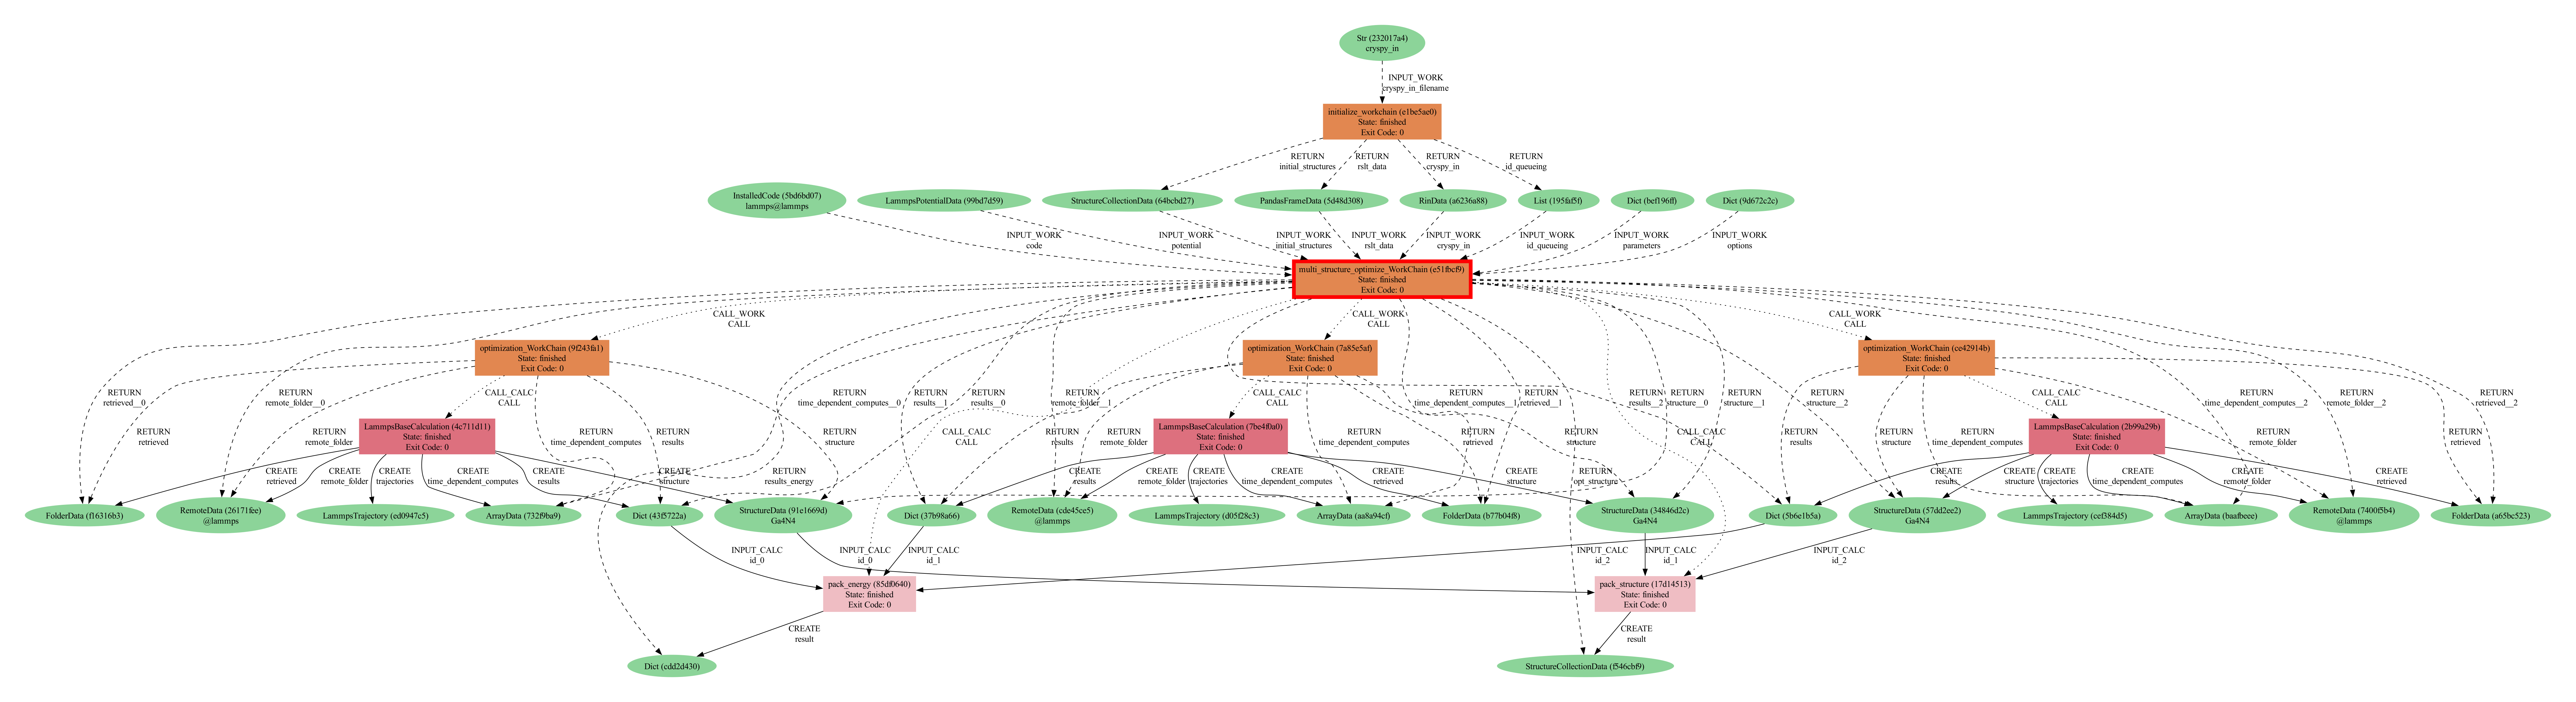

In [51]:
import subprocess
import fitz  # PyMuPDF
from PIL import Image
import io
from IPython.display import display

pk = node.pk

# Step 1: verdi コマンドで .dot.pdf を生成
subprocess.call(f"verdi node graph generate {pk}", shell=True)

# Step 2: PyMuPDF で PDF を開いて画像化
pdf_path = f"{pk}.dot.pdf"
doc = fitz.open(pdf_path)
page = doc[0]
pix = page.get_pixmap(dpi=150)

# Step 3: PIL で画像として表示
image = Image.open(io.BytesIO(pix.tobytes()))
display(image)

In [52]:
result

{'structure': {'0': <StructureData: uuid: 91e1669d-2fb3-46e0-a027-8bed3683a0f7 (pk: 7032)>,
  '1': <StructureData: uuid: 34846d2c-8350-4286-8643-348bf89fa09d (pk: 7041)>,
  '2': <StructureData: uuid: 57dd2ee2-b8af-4d78-80fe-93c8f9514c7c (pk: 7050)>},
 'remote_folder': {'0': <RemoteData: uuid: 26171fee-f1fb-4c40-a34b-09fcd72ff9a6 (pk: 7027)>,
  '1': <RemoteData: uuid: cde45ce5-7be7-4b54-85de-37514d6887e9 (pk: 7036)>,
  '2': <RemoteData: uuid: 7400f5b4-a14d-432e-bacd-cb5b60f1c733 (pk: 7045)>},
 'results': {'0': <Dict: uuid: 43f5722a-b521-4082-a31b-b3247f666ab7 (pk: 7029)>,
  '1': <Dict: uuid: 37b98a66-01b6-4d16-8258-d14e1726004f (pk: 7038)>,
  '2': <Dict: uuid: 5b6e1b5a-cd6e-40f6-8e00-eff6feb785a0 (pk: 7047)>},
 'retrieved': {'0': <FolderData: uuid: f16316b3-8239-44da-8361-ae4a6361ec15 (pk: 7028)>,
  '1': <FolderData: uuid: b77b04f8-3d0f-408e-a3b6-4d85bbe328b9 (pk: 7037)>,
  '2': <FolderData: uuid: a65bc523-8bf1-435d-84c7-3ba708a5cc46 (pk: 7046)>},
 'time_dependent_computes': {'0': <Arra

In [53]:
node.is_finished

True

In [54]:
result_energy = result['results_energy'].get_dict()
result_energy

{'index': ['id_2', 'id_0', 'id_1'],
 'energy': [-22.810743846263, -18.268981361251, 80.843135773387]}

In [55]:
result_structure = result['opt_structure'].get_dict()
result_structure

{'0': {'sites': [{'abc': [-0.051016989862937,
     0.65760003898759,
     0.61438709191764],
    'xyz': [-0.20388682141, 5.1320273291, 2.486526683],
    'label': 'Ga',
    'species': [{'occu': 1.0, 'element': 'Ga'}],
    'properties': {}},
   {'abc': [1.0510172798428, 0.34239974241153, 0.6143861099466],
    'xyz': [4.2003374368, 2.6721483141, 2.4865227088],
    'label': 'Ga',
    'species': [{'occu': 1.0, 'element': 'Ga'}],
    'properties': {}},
   {'abc': [-0.051016932517035, 0.84239983787323, 0.11438727290353],
    'xyz': [-0.20388659223, 6.5742377337, 0.46294430663],
    'label': 'Ga',
    'species': [{'occu': 1.0, 'element': 'Ga'}],
    'properties': {}},
   {'abc': [1.0510162820572, 0.1576000989811, 0.11438953197803],
    'xyz': [4.2003334492, 1.2299391227, 0.46295344948],
    'label': 'Ga',
    'species': [{'occu': 1.0, 'element': 'Ga'}],
    'properties': {}},
   {'abc': [0.56082672261865, 0.33254844498966, 0.87941760514661],
    'xyz': [2.2413156508, 2.5952670419, 3.5591492228

In [60]:
result["results"]["0"].get_dict()

{'final_emol': 0,
 'final_step': 28,
 'final_temp': 0,
 'final_epair': -18.268981361251,
 'final_press': -80491.145628072,
 'final_etotal': -18.268981361251,
 'compute_variables': {'bin': 'standard',
  'bins': [2, 4, 2],
  'errors': [],
  'binsize': 2.55,
  'warnings': [],
  'units_style': 'metal',
  'minimization': {'force_two_norm': 2.381838,
   'stop_criterion': 'energy tolerance',
   'energy_relative_difference': 7.8602417475381e-08},
  'total_wall_time': '0:00:00',
  'ghost_atom_cutoff': 5.1,
  'max_neighbors_atom': 2000,
  'total_wall_time_seconds': 0,
  'master_list_distance_cutoff': 5.1}}

In [ ]:
retrieved = result['retrieved']['0']  # IDが0の場合

# ファイル名一覧を取得
retrieved.list_object_names()  # これでファイル名のリストが得られる


['_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'aiida_lammps.trajectory.dump',
 'aiida_lammps.yaml',
 'lammps.out']

In [58]:
result['results']['2']['final_etotal']  # 結果のエネルギーを取得

-22.810743846263

In [57]:
from pymatgen.io.ase import AseAtomsAdaptor

# AiiDAのStructureDataノードを取得
structure_node = result['structure']['0']

# pymatgen Structure に変換
pymatgen_structure = structure_node.get_pymatgen_structure()

# 画面に表示（整形出力）
print(pymatgen_structure)


Full Formula (Ga4 N4)
Reduced Formula: GaN
abc   :   3.996449   7.804177   4.047166
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP            a         b         c
---  ----  ---------  --------  --------
  0  Ga    -0.051017  0.6576    0.614387
  1  Ga     1.05102   0.3424    0.614386
  2  Ga    -0.051017  0.8424    0.114387
  3  Ga     1.05102   0.1576    0.11439
  4  N      0.560827  0.332548  0.879418
  5  N      0.439173  0.667455  0.878986
  6  N      0.560828  0.167452  0.37849
  7  N      0.439173  0.832545  0.378922
